# 01 - Neuroimaging File Formats




Understanding MRI data can be tricky. Here, we'll have a look at how MRI data gets from the scanner to the computer, how it is stored and how we can make sense of it.

*Questions*

- How is MRI data stored?
- How can we convert different file formats?
- What are Nipype interfaces? What's the difference to using the command line?

*Objective*

- Convert DICOM files to NIfTI (both using the command line and nipype)

---

## Overview of neuroimaging file formats

There are different file formats to store MRI data. The most common ones are: 

- **DICOM (.dcm)**:            Digital Imaging and Communications in Medicine
- **NIfTI (.nii or .nii.gz)**: Neuroimaging Informatics Technology Initiative
- **Analyze (.img and .hdr)**
- **Minc (.minc)**

For most scanners, images are initally collected in the DICOM format. Importantly, DICOM saves one file per slice. Thus, a prolonged scanning sessions may result in hundreds or thousands of single files. This is how it looks (note that every file is named with a unique identifier):

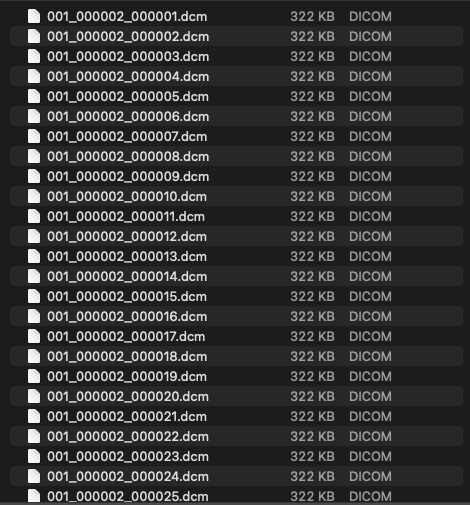

Performing complex operations on the MRI data, however, can be complicated with thousands of single files. That's why it's common to convert the DICOM files to a single NIfTI file as first step of data processing. One tool that can be used for this job is ```dcm2niix```. More information can be found [here](https://github.com/rordenlab/dcm2niix).

## Converting between neuroimaging file formats

### Setting up the environment

If you're running this notebook on Google colab, you can download a sample dicom dataset (downloaded from [here](https://wiki.idoimaging.com/index.php?title=Sample_Data)) and install ```dcm2niix``` by executing the two cells below (note that the ```!``` indicates a shell command)

In [5]:
import jupyter_black

jupyter_black.load()

In [6]:
#!pip install pydcm2niix

In [7]:
import os
import requests
import zipfile

url = "https://data.idoimaging.com/dicom/1010_brain_mr/1010_brain_mr_02_lee.zip"
extract_dir = "dicomdata"

if os.path.exists(extract_dir) == False:
    os.mkdir(extract_dir)

file = requests.get(url, verify=False)
open(extract_dir + "/" + url.split("/")[-1], "wb").write(file.content)

with zipfile.ZipFile(extract_dir + "/" + url.split("/")[-1], "r") as f:
    f.extractall(extract_dir)
    os.remove(extract_dir + "/" + url.split("/")[-1])

/home/user/miniconda3/envs/fmri/lib/python3.9/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.idoimaging.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


In the cell above we 
 - create a new directory for the dicom data
 - download the dicom data
 - unzip the compressed data.

 Furthermore, we install `pydcm2niix`, `nipype` and `nilearn` using ```pip```.

### ```dcm2niix``` as a converter tool

Originally, ```dcm2niix``` was designed for command line usage. That is, just like shell commands we learned about before (e.g., ```mkdir```, ```unzip``` or ```wget```) we can run it directly through the command line (or by suffixing a ```!``` in the case of Colab/Jupyter). This also means it doesn't come with a graphical user interface (GUI). Thus, it makes sense to have a look at the arguments (also called "flags") ```dcm2niix``` takes. You can find additional information by providing the  ``` -help```  flag  to  ```dcm2niix```: 

Now, lets convert the DICOM files to a single NIfTI file. But first we have to create an output folder:

In [8]:
nifti_dir = extract_dir + "/nifti"

if os.path.exists(nifti_dir) == False:
    os.mkdir(nifti_dir)

With our newly created output folder where are good to go and can run ```dcm2niix``` via the command line (this can also be done via Python, but more on that later). Using the ```-o``` flag we specify where the converted file should be stored:

In [ ]:
import subprocess

subprocess.run(
    [
        "dcm2niix",
        "-o ",
        nifti_dir,
        " y ",
        extract_dir + "/" + url.split("/")[-1].replace(".zip", ""),
    ]
)

Great! In the output there should be now two files: One with a ```.nii``` file extension (this is our data) and one with ```.json``` file extension (this is a so called json sidecar where DICOM metadata is preserved)

### ```dcm2niix``` as a Nipype interface

Above we have converted the DICOM files using the command line. However, we can also run ```dcm2niix``` within Python by using the respective **Nipype** interface.


#### What's Nipype about?

You will learn more about Nipype in the upcoming weeks (and by actualling applying it). For starters, Nipype is an open-source project that allows for integrating a variety of different neuroimaging softwares into a single workflow (and there are *a lot* of different software tools for neuroimaging analysis, like [SPM](https://www.fil.ion.ucl.ac.uk/spm/software/), [FSL](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki) or [AFNI](https://afni.nimh.nih.gov) - just to name a few of them).

In Nipype's context *interfaces* are wrappers that allow Nipype to run programs that are written in languages other than Python (like ```dcm2niix``` for example). This way, we can integrate virtually every available neuroimaging tool within the same environment. You can find a small tutorial on interfaces [here](https://nipype.readthedocs.io/en/0.11.0/users/interface_tutorial.html).

#### Using Nipype to convert dicoms

Before we start using ```dcm2niix``` as a Nipype interface, let's create a new output folder:

In [10]:
nifti_nipype_dir = extract_dir + "/nifti_nipype"

if os.path.exists(nifti_nipype_dir) == False:
    os.mkdir(nifti_nipype_dir)

Now we have to import the ```Dcm2niix``` [class](https://docs.python.org/3/tutorial/classes.html) that wraps the functionality of the program within Python. 

The ```nipype.interfaces``` module gives us access to several external software packages. You can find a list of all the available packages [here](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.html).

Now, let's import the ```Dcm2niix``` class from the [dcm2nii module](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.dcm2nii.html):

In [11]:
from nipype.interfaces.dcm2nii import Dcm2niix

First, let's have a look at the [docstring](https://peps.python.org/pep-0257/) of the ```Dcm2niix``` class (further information can be found in the official [documentation](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.dcm2nii.html#dcm2niix)):

In [12]:
?Dcm2niix

Init signature: Dcm2niix(command=None, terminal_output=None, write_cmdline=False, **inputs)
Docstring:     
Uses Chris Rorden's dcm2niix to convert dicom files

Examples

>>> from nipype.interfaces.dcm2nii import Dcm2niix
>>> converter = Dcm2niix()
>>> converter.inputs.source_dir = 'dicomdir'
>>> converter.inputs.compression = 5
>>> converter.inputs.output_dir = 'ds005'
>>> converter.cmdline
'dcm2niix -b y -z y -5 -x n -t n -m n -o ds005 -s n -v n dicomdir'
>>> converter.run() # doctest: +SKIP

In the example below, we note that the current version of dcm2niix
converts any files in the directory containing the files in the list. We
also do not support nested filenames with this option. **Thus all files
must have a common root directory.**

>>> converter = Dcm2niix()
>>> converter.inputs.source_names = ['functional_1.dcm', 'functional_2.dcm']
>>> converter.inputs.compression = 5
>>> converter.inputs.output_dir = 'ds005'
>>> converter.cmdline
'dcm2niix -b y -z y -5 -x n -t n -m n -o ds00

Note how this info relates to the info we got when running ```dcm2niix``` as a command line tool and by passing the ```-help``` flag.

The first step when using interfaces is always to create an object (or: instance) of the respective interface class (in this case the ```Dcm2niix``` class):

In [13]:
converter = Dcm2niix()

For ```dcm2niix``` to run we need to provide two mandatory arguments - input and output directory:

In [14]:
converter.inputs.source_dir = extract_dir + "/" + url.split("/")[-1].replace(".zip", "")
converter.inputs.output_dir = nifti_nipype_dir

Besides input and output directory names, there are further (optional) attributes attached to the ```Dcm2niix``` object (you can list all of them by using the command ```print(dir(converter))```).

One attribute that you can find in almost every Nipype class is called ```cmdline```. It basically tells us the way the command will be run on our computer. Remember that Nipype is just a wrapper - "under the hood" ```dcm2niix``` will be run the same way as above when we used it directly as a command line tool. Thus you can think of Nipype as a way to set up these commands within a Python environment (with the main benefit being the ability to integrate a wide variety of different software tools).

Alright, let's have a look at the command that Nipype has created for us:

In [15]:
print(converter.cmdline)

dcm2niix -b y -z y -x n -t n -m n -o dicomdata/nifti_nipype -s n -v n dicomdata/1010_brain_mr_02_lee


Note that there are way more flags included in the command Nipype created compared the one we created ourselves above. This is because a lot of optional functionalities are turned on by default. For example, the attribute ```bids_format``` (which maps to the command line flag ```-b```) is set to ```True``` by default. Check the [documentation](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.dcm2nii.html#dcm2niix) of the class to see how the different attributes relate to the command line arguments.

Now that we have instantiated our ```Dcm2niix``` object and provided the mandatory inputs we can go ahead and run the interface using the ```run()``` method. This procedure is common to almost all Nipype interface: First, instanstiate the object of a specific interface class, provide mandatory and optional inputs and then actually run it by using the ```run()``` method.

In [ ]:
converter.run()

Have a look at Colab's (or your local machine's) file browser to see whether a ```.nii```/```.nii.gz``` has been created in the output directory.

## Exercise

First, in the dicomdata directory, create a new output directory called ```nifti-nipype-2```. Then, convert the dicom files using the Nipype interface and store the results in the newly created directory. For this job, use an compression level of 5 (Tip: you can have a look at the documentation using ```?Dcm2niix``` to find the appropriate option).

Finally, plot the NIfTI file using Nilearn.

In [76]:
import nilearn as nil
import nibabel as nib
import scipy.ndimage as ndi
from glob import glob
import matplotlib.pyplot as plt

In [72]:
%matplotlib inline

In [ ]:
nifti_nipype_2_dir = extract_dir + "/nifti-nipype-2"

os.mkdir(nifti_nipype_2_dir)

converter = Dcm2niix()

converter.inputs.compression = 5
converter.inputs.source_dir =  extract_dir + '/' + url.split('/')[-1].replace(".zip", "")
converter.inputs.output_dir = nifti_nipype_2_dir

converter.run()

In [53]:
nii_gz_file = glob(nifti_nipype_2_dir + "/*.nii.gz")[0]

In [54]:
ni_data = nib.load(nii_gz_file)

# What is the type of this object?
type(ni_data)

nibabel.nifti1.Nifti1Image

In [61]:
print(ni_data.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 54
dim             : [  3 192 256 192   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [1.    1.    1.    1.    0.019 0.    0.    0.   ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'TE=4.9;Time=1157.647'
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.015707318
quatern_c       : 1.6108353e-12
quatern_d       : -1.02539054e-10
qoffset_x       : -97.42131
qoffset_y       : 

In [62]:
ni_data_np = ni_data.get_fdata()
type(ni_data_np)

numpy.ndarray

In [63]:
ni_data_np.shape

(192, 256, 192)

Plotting a slice

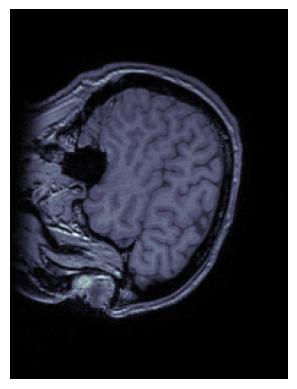

In [81]:
plt.imshow(ni_data_np[45], cmap='bone')
plt.axis('off')
plt.show()

Rotate

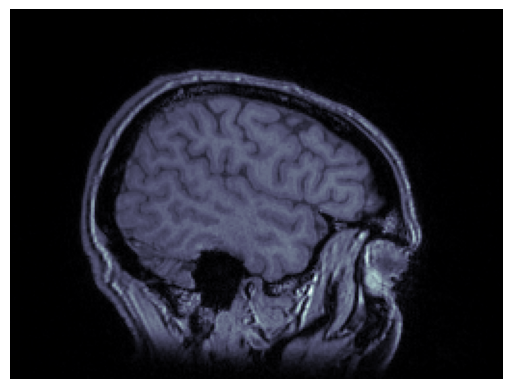

In [82]:
plt.imshow(ndi.rotate(ni_data_np[45], 90), cmap='bone')
plt.axis('off')
plt.show()

/home/user/miniconda3/envs/fmri/lib/python3.9/site-packages/nilearn/image/resampling.py:545: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


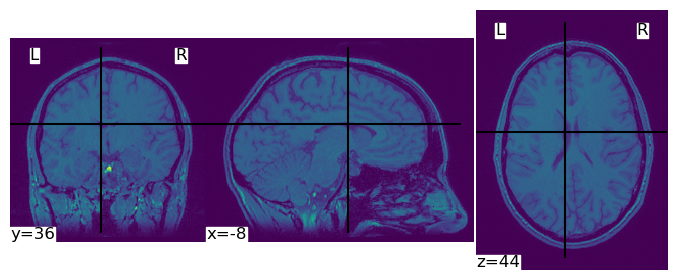

In [84]:
from nilearn import plotting

plotting.plot_img(ni_data)
plt.show()

Customize plot a little

/home/user/miniconda3/envs/fmri/lib/python3.9/site-packages/nilearn/image/resampling.py:545: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


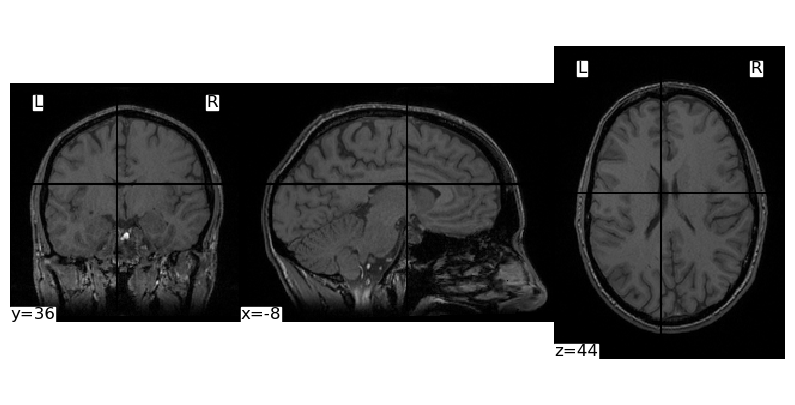

In [85]:
fig, ax = plt.subplots(figsize=[10, 5])
plotting.plot_img(ni_data, cmap='gray', axes=ax)
plt.show()

Taken from here: https://neuraldatascience.io/8-mri/nifti.html

## Resources

[The NIFTI file format](https://brainder.org/2012/09/23/the-nifti-file-format/): Comprehensive overview of the contents of the Nifti file format 

[MRI analysis in Python using Nipype, Nilearn and more](https://peerherholz.github.io/workshop_weizmann/index.html): Very neat Jupyter book covering different aspects of MRI analysis in Python (by [by Peer Herholz](https://peerherholz.github.io)). Also includes a nice [presentation](https://docs.google.com/presentation/d/e/2PACX-1vSuwfkKyYh0qMZzRO4vM0lG6A2XGA_JxQxGl1Cw_wSyK40jaceCg-emUJQxB-49VMMcAXadd4WKgMJv/embed?start=false&amp;loop=false&amp;delayms=3000&amp;usp=embed_facebook&slide=id.g8074ffaf2c_0_0) on Nipype and the ecosystem around it

[Dartbrains](https://dartbrains.org/content/intro.html): Very comprehensive course on fMRI analysis using Python, covering mathematical/statistical fundamentals (by [Luke Chang](http://www.lukejchang.com))

[NiPraxis](https://textbook.nipraxis.org/intro.html): Another course going very deep and covering both practise and theory of brain imaging. 

[Neuroimaging and Data Science](https://neuroimaging-data-science.org/root.html): "Introduction to contemporary data science and its application in neuroimaging research" (by Ariel Rokem & Tal Yarkoni). Again, going way deeper than the scope of our course.

## References

Michael Joseph, Jerrold Jeyachandra, and Erin Dickie (eds):
"Data Carpentry: Introduction to MRI Data Analysis." Version 2019.11, November 2019,
https://github.com/carpentries-incubator/SDC-BIDS-IntroMRI
